# **LAB 2 REDES NEURONALES PYTORCH**

# Implementación del modelo - Red Neuronal

Link del Dataset: https://www.kaggle.com/datasets/andrewmvd/medical-mnist

Link del Repositorio de GitHub LAB-02: 

In [1]:
import os
import numpy as np
import PIL
from PIL import Image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
print("Todo instalado correctamente")

Todo instalado correctamente


# **1. Preprocesamiento de los Datos**

# Carga del Dataset Medical MNIST

## Organización de Carpetas y Etiquetas
El dataset **Medical MNIST** está organizado en carpetas, cada una representando una clase de imágenes médicas:

| Clase       | Etiqueta (`y`) |
|------------|---------------|
| Tomografía Computarizada de Abdomen  | 0 |
| Resonancia Magnética de mama | 1 |
| Tomografía computarizada de Tórax    | 2 |
| Radiografía de Tórax        | 3 |
| Radiografía de Mano       | 4 |
| Tomografía Computarizada de la Cabeza     | 5 |

Las imágenes dentro de cada carpeta ya están en **escala de grises** y tienen un tamaño de **64x64 píxeles**.


In [2]:
dataset_path = r"C:\Users\diego\Documents\USFX\IA\Datasets\Radiografias" 
clases = sorted(os.listdir(dataset_path))  
num_clases = len(clases)

print(f"Clases encontradas: {clases}")
print(f"Cantidad de clases: {num_clases}")

Clases encontradas: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Cantidad de clases: 6


## SE CARGAN LOS DATOS DEL DATASET
se cargan las imagenes del dataset para el entrenamiento

In [3]:
x, y = [], []
x_test, y_test = [], []

for label, clase in enumerate(clases): 
    clase_path = os.path.join(dataset_path, clase) 

    if not os.path.isdir(clase_path):
        continue
    
    contador = 0

    for img_name in os.listdir(clase_path):
        img_path = os.path.join(clase_path, img_name)

        try:
            img = Image.open(img_path)
            img_array = np.array(img).flatten()  #4096

            if contador < 8000:
                x.append(img_array)
                y.append(label)
            else:
                x_test.append(img_array)
                y_test.append(label)
            
            contador += 1
        except Exception as e:
            print(f"Error con {img_path}: {e}")

Convertimos nuestros datos a arrays NumPy y normalizamos los valores de píxeles al rango [0,1]

In [4]:
x_train = np.array(x, dtype=np.float32)/255  
y_train = np.array(y, dtype=np.int64)

x_test = np.array(x_test, dtype=np.float32)/255
y_test = np.array(y_test, dtype=np.int64)

print(f"X shape: {x_train.shape}, y shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

X shape: (48000, 4096), y shape: (48000,)
X_test shape: (10954, 4096), y_test shape: (10954,)


# Definición de la Red Neuronal
A continuación definimos nuestra red neuronal. Utilizaremos una arquitectura con múltiples capas ocultas para cumplir con los requisitos

In [5]:
class MedicalMNIST_NN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MedicalMNIST_NN, self).__init__()
        
        # Primera capa oculta 
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()

        
        # Segunda capa oculta 
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()

        
        # Capa de salida
        self.fc4 = nn.Linear(hidden_size2, output_size)
        
        self.activations = {}
    
    def forward(self, x):
        # Capa 1
        x = self.fc1(x)
        x = self.relu1(x)
        self.activations['capa1'] = x.detach()
        # Capa 2
        x = self.fc2(x)
        x = self.relu2(x)
        self.activations['capa2'] = x.detach()
        # Salida
        x = self.fc4(x)
        self.activations['capa_salida'] = x.detach()
        return x
    
    def get_activations(self):
        return self.activations

# Implementación del Modelo
Definimos los parámetros de nuestra red y creamos una instancia

In [6]:
input_size = 4096  
hidden_size1 = 256 
hidden_size2 = 128 
output_size = num_clases  

model = MedicalMNIST_NN(input_size, hidden_size1, hidden_size2, output_size)

if torch.cuda.is_available():
    model = model.to("cuda")
    print("Modelo transferido a GPU")

Modelo transferido a GPU


# Función de Pérdida y Optimizador
Utilizamos Cross Entropy Loss para problemas de clasificación multiclase y el optimizador SGD

In [7]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=0.08)  

# Entrenamiento de la Red
Ahora entrenaremos nuestra red neuronal 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_t = torch.from_numpy(x_train).float().to(device)
Y_t = torch.from_numpy(y_train).long().to(device)

In [9]:
print(f"X_t shape: {X_t.shape}, Y_t shape: {Y_t.shape}")

X_t shape: torch.Size([48000, 4096]), Y_t shape: torch.Size([48000])


In [10]:
epochs = 1000
log_each = 50 
losses = []

model.train()
for e in range(1, epochs + 1):
    y_pred = model(X_t)
    loss = criterion(y_pred, Y_t)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if not e % log_each:
        print(f"Epoch {e}/{epochs} Loss {loss.item():.4f}")

Epoch 50/1000 Loss 0.4286
Epoch 100/1000 Loss 0.3199
Epoch 150/1000 Loss 0.3538
Epoch 200/1000 Loss 0.2025
Epoch 250/1000 Loss 0.2757
Epoch 300/1000 Loss 0.1606
Epoch 350/1000 Loss 0.1195
Epoch 400/1000 Loss 0.1366
Epoch 450/1000 Loss 0.1282
Epoch 500/1000 Loss 0.0789
Epoch 550/1000 Loss 0.0722
Epoch 600/1000 Loss 0.0933
Epoch 650/1000 Loss 0.0539
Epoch 700/1000 Loss 0.0479
Epoch 750/1000 Loss 0.0435
Epoch 800/1000 Loss 0.0401
Epoch 850/1000 Loss 0.0371
Epoch 900/1000 Loss 0.0346
Epoch 950/1000 Loss 0.0324
Epoch 1000/1000 Loss 0.0304


# Evaluación del Modelo
Evaluamos el rendimiento de nuestro modelo en el conjunto de prueba

In [11]:
def evaluate_model(model, x_test, y_test):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_test_tensor = torch.from_numpy(x_test).float().to(device)
    model.eval()
    
    with torch.no_grad():
        outputs = model(X_test_tensor)
        loss = criterion(outputs, torch.LongTensor(y_test).to(device)).item()
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        y_pred = predicted.cpu().numpy()
    accuracy = accuracy_score(y_test, y_pred) * 100
    
    print(f"Precisión: {accuracy:.2f}%")
    print(f"Error: {loss:.4f}")
    
    if accuracy > 90 and loss < 0.05:
        print("Cumple con los objetivos (precisión >90%, error <5%)")
    else:
        print("No cumple con los objetivos")
    
    return accuracy, loss, y_pred
accuracy, loss, predictions = evaluate_model(model, x_test, y_test)

tensor([0, 0, 0,  ..., 5, 5, 5], device='cuda:0')
Precisión: 98.96%
Error: 0.0425
Cumple con los objetivos (precisión >90%, error <5%)


# Curva de Aprendizaje
También podemos visualizar cómo evoluciona la pérdida durante el entrenamiento

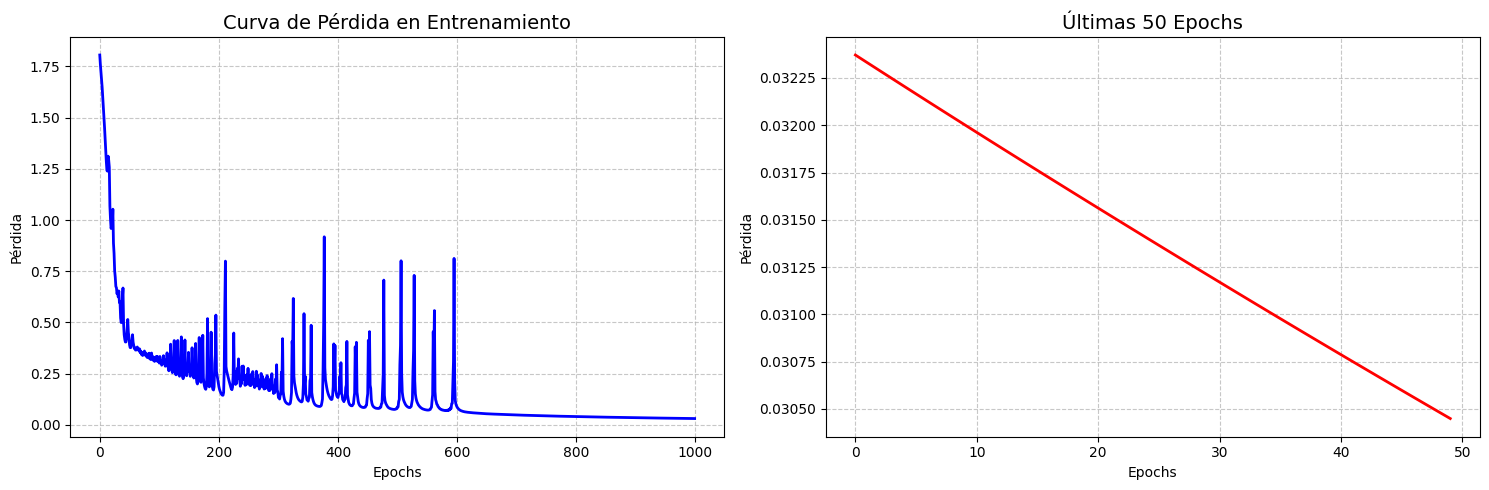

Pérdida inicial: 1.805854
Pérdida final: 0.030449
Reducción de pérdida: 98.31%


In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, color='blue', linewidth=2)
plt.title('Curva de Pérdida en Entrenamiento', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.grid(True, linestyle='--', alpha=0.7)

small_window = min(50, len(losses))
if len(losses) > 10:
    plt.subplot(1, 2, 2)
    plt.plot(losses[-small_window:], color='red', linewidth=2)
    plt.title(f'Últimas {small_window} Epochs', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Pérdida')
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
print(f"Pérdida inicial: {losses[0]:.6f}")
print(f"Pérdida final: {losses[-1]:.6f}")
print(f"Reducción de pérdida: {100 * (losses[0] - losses[-1]) / losses[0]:.2f}%")

# Visualización de las capas

tensor([[ 8.0791, -4.0518,  0.2321, -6.1555,  2.6838,  1.1523]],
       device='cuda:0')


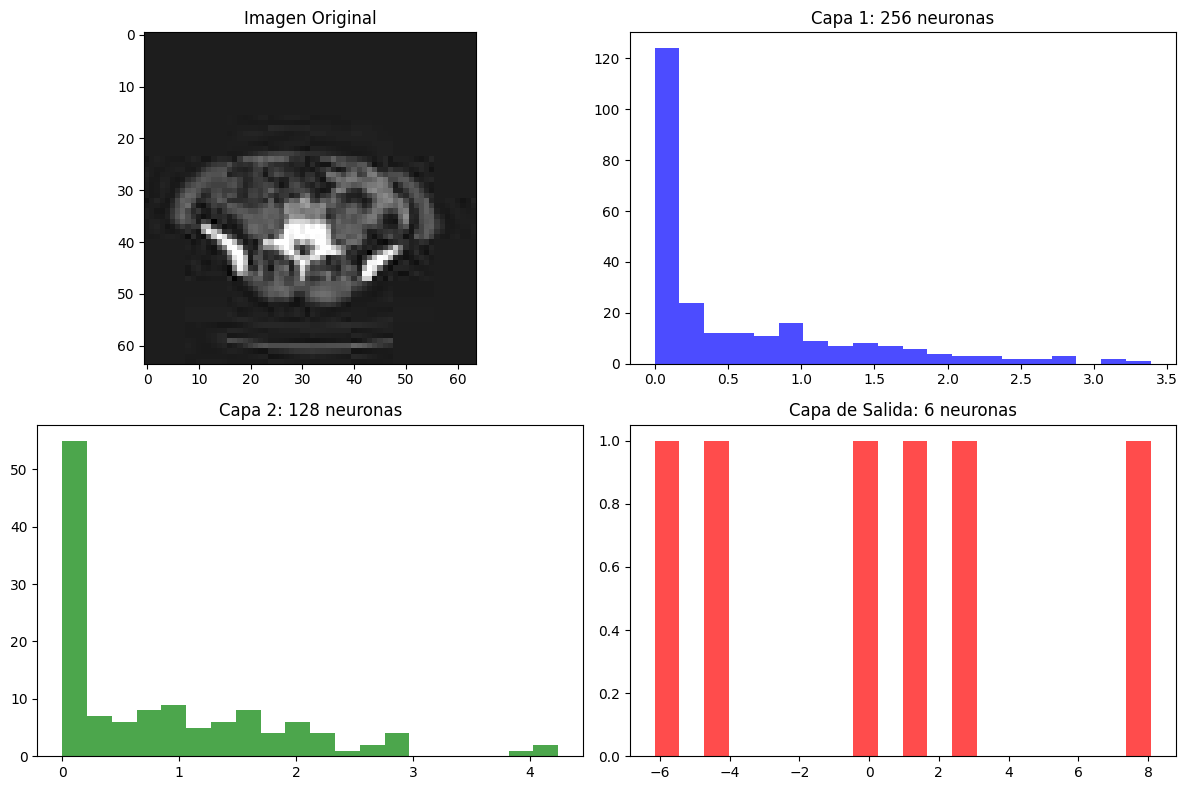

Información de las capas:
- Capa 1: 256 neuronas, Media: 0.5695
- Capa 2: 128 neuronas, Media: 0.8389
- Capa de Salida: 6 neuronas, Media: 0.3234


In [ ]:
def visualizar_capas_ocultas_simple(model, muestra):
    model.eval()
    muestra = muestra.to(device)
    with torch.no_grad():
        pred1 = model(muestra)
    
    activaciones = model.get_activations()
    print(pred1)
    plt.figure(figsize=(12, 8))
    # Imagen original
    plt.subplot(2, 2, 1)
    img = muestra.cpu().numpy()[0].reshape(64, 64)
    plt.imshow(img, cmap='gray')
    plt.title('Imagen Original')
    
    # Activaciones capa 1
    plt.subplot(2, 2, 2)
    act1 = activaciones['capa1'].cpu().numpy()[0]
    plt.hist(act1, bins=20, color='blue', alpha=0.7)
    plt.title(f'Capa 1: {len(act1)} neuronas')
    
    # Activaciones capa 2
    plt.subplot(2, 2, 3)
    act2 = activaciones['capa2'].cpu().numpy()[0]
    plt.hist(act2, bins=20, color='green', alpha=0.7)
    plt.title(f'Capa 2: {len(act2)} neuronas')

    # Activaciones capa de salida
    if 'capa_salida' in activaciones:
        plt.subplot(2, 2, 4)
        act_salida = activaciones['capa_salida'].cpu().numpy()[0]
        plt.hist(act_salida, bins=20, color='red', alpha=0.7)
        plt.title(f'Capa de Salida: {len(act_salida)} neuronas')
    else:
        print("No se encontró la capa de salida en las activaciones del modelo.")

    plt.tight_layout()
    plt.show()
    
    # Información de las capas
    print("Información de las capas:")
    print(f"- Capa 1: {len(act1)} neuronas, Media: {act1.mean():.4f}")
    print(f"- Capa 2: {len(act2)} neuronas, Media: {act2.mean():.4f}")
    
    # Si existe la capa de salida, mostrar su información
    if 'capa_salida' in activaciones:
        print(f"- Capa de Salida: {len(act_salida)} neuronas, Media: {act_salida.mean():.4f}")
        
muestra = torch.FloatTensor(x_test[2:3]).to(device) 
visualizar_capas_ocultas_simple(model, muestra)
